## Parkinsons Disease Detection with Python

This project aims at detecting Parkinsons thorugh machine learning some real data. We have used the UCI ML Parkinsons dataset, available at: https://archive.ics.uci.edu/ml/datasets/parkinsons

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading the data file from webpage
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

In [3]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

There are as many as 22 features, but no missing values

In [5]:
df.groupby('status').count()['name']

status
0     48
1    147
Name: name, dtype: int64

Data is biased towars positive. Thus null accuracy would be rather high

### Train-Test Splitting of Data

In [6]:
# features and labels are singled out of the dataframe

X = df.drop(['name','status'],axis=1)
y = df['status']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Features

Pairwise correlation of features, if high, may suggest throwing away some of the features

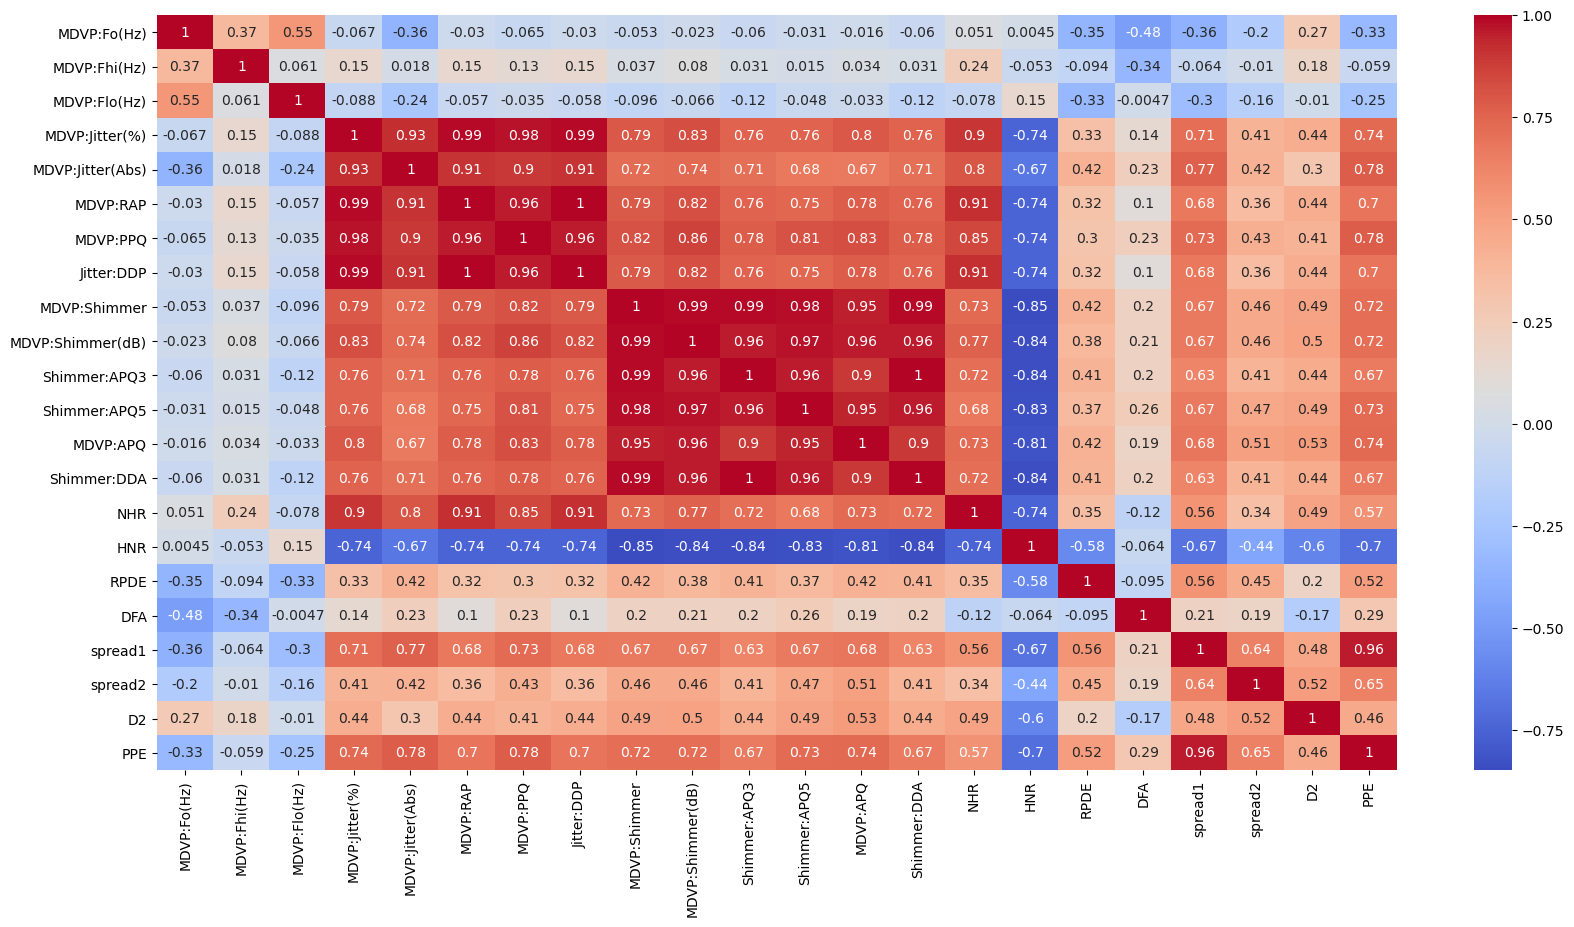

In [7]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(X_train.corr(),cmap='coolwarm',annot=True)

There are many highly correlated pairs. Some features could be thrown away by PCA

### Principal Component Analysis

In [8]:
from sklearn.preprocessing import StandardScaler

# feature scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

To see how many principal components may be needed, let us plot cumulative explained variance (screeplot)

Text(0, 0.5, 'Cumulative explained variance')

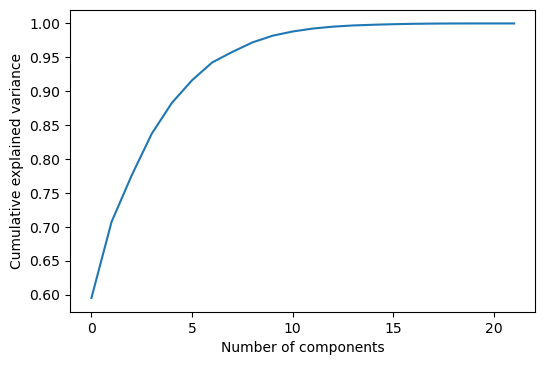

In [9]:
from sklearn.decomposition import PCA

# making the list of cumulative explained variance
pca = PCA().fit(X_train_std)
cumsum_list = pca.explained_variance_ratio_.cumsum()

# making the screeplot
plt.figure(dpi=100)
plt.plot(cumsum_list)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We will retain as many principal components as account for 99% cumulative variance:

In [10]:
model = PCA(n_components=0.99, svd_solver='full')
model.fit(X_train_std)
model.n_components_ 

12

The number of principal components to retain is 12

In [11]:
X_train.shape

(156, 22)

In [12]:
model.transform(X_train_std).shape

(156, 12)

### Hyperparameter tuning with cross-validation

In [13]:
# import the various classifiers to be expored

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

clf = {'Logistic Regression': LogisticRegression(),
       'K Neighbors': KNeighborsClassifier(), 
       'Support Vector': SVC(), 
       'Gaussian NB': GaussianNB(),
       'Decision Tree': DecisionTreeClassifier(), 
       'Random Forest': RandomForestClassifier(), 
       'XG Boost': XGBClassifier(use_label_encoder=False, eval_metric='auc')}

In [14]:
# Dictionary of tunable hyperparameters of various classifiers

from scipy.stats import expon

hp = {'K Neighbors': dict(n_neighbors = list(range(1,31)),
                          metric = ['euclidean', 'manhattan', 'minkowski'], 
                          weights = ['uniform', 'distance']),
      'Logistic Regression': dict(C = 10.**np.arange(-3, 3),
                                  penalty = ['l1', 'l2', 'elasticnet']),
      'Decision Tree': dict(criterion = ['gini', 'entropy'],
                            min_samples_leaf = list(range(1,10)),
                            max_depth = list(range(2,14,2))),
      'Support Vector': dict(C = expon(scale=100),      # param distribution for SVC 
                             gamma = expon(scale=.1)),
      'Random Forest': dict(n_estimators = [10,50,100,500,1000],
                            max_features = ['auto', 'sqrt', 'log2']),
      'XG Boost': dict(learning_rate = 0.1*np.arange(1,11), # default = 0.3
                       max_depth = list(range(2,31,2)),  # default = 6
                       min_child_weight = 10.**np.arange(-2,3), # default = 1
                       min_split_loss = 0.1**np.arange(0,5), # default = 0
                       colsample_bytree = 0.1*np.arange(1,11)), # default = 1
      'Gaussian NB': dict(priors = [None], var_smoothing = [1e-09])} # default values only

In [15]:
# creating a dictionary for best estimators
best_values = {}

In [16]:
# define function for grid serach/randomized serach of best hyperparameters

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import time

def best_estimator(clf_name,X_,y_,cv_,rs_=False,n_iter=None):
    '''This function finds best estimator for a given classifier'''
    ti = time.time()
    if rs_:
        grid = RandomizedSearchCV(clf[clf_name], param_distributions=hp[clf_name], 
                                  n_iter=n_iter, scoring='accuracy', n_jobs=-1, cv=cv_)
    else:
        grid = GridSearchCV(clf[clf_name], param_grid=hp[clf_name], 
                        scoring='accuracy', n_jobs=-1, cv=cv_)
    pipeline = Pipeline([('sc',StandardScaler()), 
                         ('pca',PCA(n_components=0.99, svd_solver='full')), 
                         ('grid',grid)])
    pipeline.fit(X_,y_)
    
    best_score = round(100*grid.best_score_,1)
    best_pipeline = Pipeline([('sc',StandardScaler()), 
                              ('pca',PCA(n_components=0.99, svd_solver='full')), 
                              ('best_est',grid.best_estimator_)])
    
    tf = time.time()
    time_ = round(tf-ti,1)
    
    best_values[clf_name] = [best_score, best_pipeline, time_]
    
    print(clf_name+' took '+str(time_)+' sec; best train accuracy: '+str(best_score)+'%')

In [17]:
# hyperparameter tuning for Logistic Regression

best_estimator('Logistic Regression',X_train,y_train,cv_=10)

Logistic Regression took 2.1 sec; best train accuracy: 85.2%


In [18]:
# hyperparameter tuning for K Neighbors

best_estimator('K Neighbors',X_train,y_train,cv_=10)

K Neighbors took 1.2 sec; best train accuracy: 94.9%


In [19]:
# hyperparameter tuning for Support vector

best_estimator('Support Vector',X_train,y_train,cv_=10,rs_=True,n_iter=1000)

Support Vector took 5.7 sec; best train accuracy: 94.2%


In [20]:
# Gaussian NB (no tuning, just default hyperparameters)

best_estimator('Gaussian NB',X_train,y_train,cv_=10)

Gaussian NB took 0.0 sec; best train accuracy: 76.9%


In [21]:
# hyperparameter tuning for Decision Tree

best_estimator('Decision Tree',X_train,y_train,cv_=10)

Decision Tree took 0.7 sec; best train accuracy: 84.6%


In [22]:
# hyperparameter tuning for Random Forest

best_estimator('Random Forest',X_train,y_train,cv_=10)

Random Forest took 21.2 sec; best train accuracy: 86.6%


In [23]:
# hyperparameter tuning for XG Boost

best_estimator('XG Boost',X_train,y_train,cv_=10,rs_=True,n_iter=100)

XG Boost took 24.2 sec; best train accuracy: 91.0%


In [24]:
# dataframe for best training scores

def best_list(index):
    return [list(best_values.values())[i][index] for i in range(len(best_values))]
        
best_new = {'Best Score (%)': best_list(0), 'Search Time (sec)': best_list(2)}
df_best = pd.DataFrame(index=best_values.keys(), data=best_new, columns=best_new.keys())

# null accuracy for training data
null_train = round(100*max(y_train.mean(),1-y_train.mean()),1)

# discard bad classifiers, if any, which give accuracy close to the null value
df_best = df_best[df_best['Best Score (%)']>(null_train+5.0)]

In [25]:
df_best

,Best Score (%),Search Time (sec)
Logistic Regression,85.2,2.1
K Neighbors,94.9,1.2
Support Vector,94.2,5.7
Decision Tree,84.6,0.7
Random Forest,86.6,21.2
XG Boost,91.0,24.2


### Performance on test data

In [26]:
# define function for evaluating various metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

def test_result(clf_name,X_,y_,X_new,y_new):
    '''This function evaluates various performance metrics on test data'''
 
    best_pipeline = best_values[clf_name][1]
    best_pipeline.fit(X_,y_)
    y_pred = best_pipeline.predict(X_new)
    
    accuracy = round(accuracy_score(y_new,y_pred),3)
    precision = round(precision_score(y_new,y_pred),3)
    recall = round(recall_score(y_new,y_pred),3)
    f1 = round(f1_score(y_new,y_pred),3)
    
    return accuracy, precision,recall, f1

In [27]:
# create a dataframe of performance metrics

metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'f1 Score': []}
for estimator in df_best.index:
    accuracy,precision,recall,f1 = test_result(estimator,X_train,y_train,X_test,y_test)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['f1 Score'].append(f1)

df_result = pd.DataFrame(index=df_best.index, data=metrics, columns=metrics.keys())

In [28]:
df_result

,Accuracy,Precision,Recall,f1 Score
Logistic Regression,0.872,0.897,0.929,0.912
K Neighbors,0.949,1.000,0.929,0.963
Support Vector,0.974,1.000,0.964,0.982
Decision Tree,0.846,0.958,0.821,0.885
Random Forest,0.949,0.964,0.964,0.964
XG Boost,0.923,1.000,0.893,0.943


Support Vector Classifier is the best performer

In [29]:
# null accuracy for test data

null_test = round(100*max(y_test.mean(),1-y_test.mean()),1)
print('Null accuracy for test data: {}%'.format(null_test))

Null accuracy for test data: 71.8%


### Voting classifier of 3 estimators

In [30]:
from sklearn.ensemble import VotingClassifier

def voting_(voter_list,vote_type):
    '''This function creates a voting classifier of 3 estimators,
    which is subsequently trained and tested'''
    
    # creating voting classifier
    estimator_list = []
    for clf_name in voter_list:
        estimator_list.append((clf_name,best_values[clf_name][1]))
    voting_clf = VotingClassifier(estimators=estimator_list,voting=vote_type)
    
    # training and testing
    voting_clf.fit(X_train,y_train)
    y_pred = voting_clf.predict(X_test)
    
    # evaluation of metrics
    accuracy = round(accuracy_score(y_test,y_pred),3)
    precision = round(precision_score(y_test,y_pred),3)
    recall = round(recall_score(y_test,y_pred),3)
    f1 = round(f1_score(y_test,y_pred),3)
    
    return accuracy, precision, recall, f1

In the voter list, let us choose the bottom 3 performers (in terms of accuracy with training data)

In [31]:
# create voter list
voter_list = []
cutoff = sorted(df_best['Best Score (%)'])[2]
for estimator in df_best.index:
    if df_best['Best Score (%)'][estimator] <= cutoff:
        voter_list.append(estimator)
print('voter list: ', voter_list)

voter list:  ['Logistic Regression', 'Decision Tree', 'Random Forest']


In [32]:
# create a dataframe of performance metrics

voting_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'f1 Score': []}
for vote_type in ['hard','soft']:
        accuracy, precision, recall, f1 = voting_(voter_list,vote_type)
        voting_metrics['Accuracy'].append(accuracy)
        voting_metrics['Precision'].append(precision)
        voting_metrics['Recall'].append(recall)
        voting_metrics['f1 Score'].append(f1)

df_voting = pd.DataFrame(index=['Hard Voting','Soft Voting'],
                         data=voting_metrics, columns=voting_metrics.keys())

In [33]:
df_voting

,Accuracy,Precision,Recall,f1 Score
Hard Voting,0.923,0.963,0.929,0.945
Soft Voting,0.897,0.962,0.893,0.926


Voting of the bottom three classifiers also performed very well on test data 